In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("Solarize_Light2")
%matplotlib inline
from DAmethod.ETKF import ETKF


## Model definition and example of forward model
We import the Lorenz93Model class, set its dimension (as a class variable)

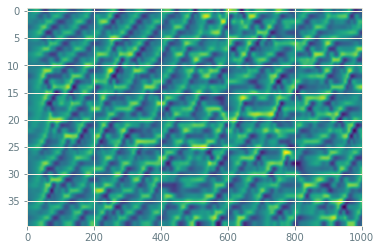

In [2]:
from dynamicalsystems.lorenz93 import Lorenz93Model

# Set class variable
state_dimension = 40
Lorenz93Model.dim = state_dimension
lorenz40 = Lorenz93Model()
x0 = np.random.normal(0, 1, lorenz40.dim)
lorenz40.set_initial_state(0, x0)
lorenz40.forward(1000)
plt.imshow(lorenz40.state_vector, aspect="auto")
plt.show()

## Truth definition
We introduce the "truth", which is a Lorenz93Model, with specified initial condition. We use a burn-in period of 1000 timesteps

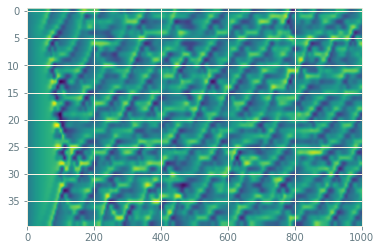

In [3]:
truth = Lorenz93Model()
x0 = np.zeros(state_dimension)
x0[0] = 1
truth.set_initial_state(-1000 * truth.dt, x0)
truth.forward(1000)
plt.imshow(truth.state_vector, aspect="auto")
plt.show()

We define a function to generate a projector,  observation operator $H$:


In [4]:
def create_projector(n: int, m: int, indices) -> np.ndarray:
    """Create a projector from a space of n dimension to m, where the identity is applied to the indices 

    :param n: input dimension
    :type n: int
    :param m: output dimension
    :type m: int
    :param indices: indices to keep
    :type indices: Iterable
    :return: Projection matrix
    :rtype: np.ndarray
    """    
    H = np.zeros((m, n))
    for i in indices:
        H[i, i] = 1
    return H

In [5]:
period_assim = 2
sigobs = 1
Nensemble = 16
dim_observations = 5 #state_dimension // 2
H = create_projector(state_dimension, dim_observations, np.arange(dim_observations))
R = sigobs * np.eye(dim_observations)
inflation_factor=1.05

In [6]:
def generate_observations(i):
    truth.forward(period_assim)
    y = truth.state_vector[:, -1] + np.random.randn(state_dimension) * sigobs
    return truth.t[-1], y

def observation_generator():
    truth.set_initial_state(-1000 * truth.dt, x0, force_reset=True)
    truth.forward(1000)
    print("Truth initialized")
    i = 0
    while True:
        yield generate_observations(i)
        i += 1

In [7]:
etkf = ETKF(state_dimension, Nensemble, R, inflation_factor)
etkf.set_forwardmodel(lambda x: Lorenz93Model.integrate(0, x, period_assim,)[1][:, -1])
etkf.H = H
etkf.R = R #TODO verify how to call properly the setter at the __init__
siginit = 0.1
initial_state = truth.state_vector[:, -1]
covariance = siginit * np.eye(state_dimension)
etkf.generate_ensemble(mean=initial_state, cov=covariance)
Yf, Yfhat = etkf.observation_anomalies()


In [8]:
Nsteps = 800
dETKF = etkf.run(Nsteps, generate_observations)

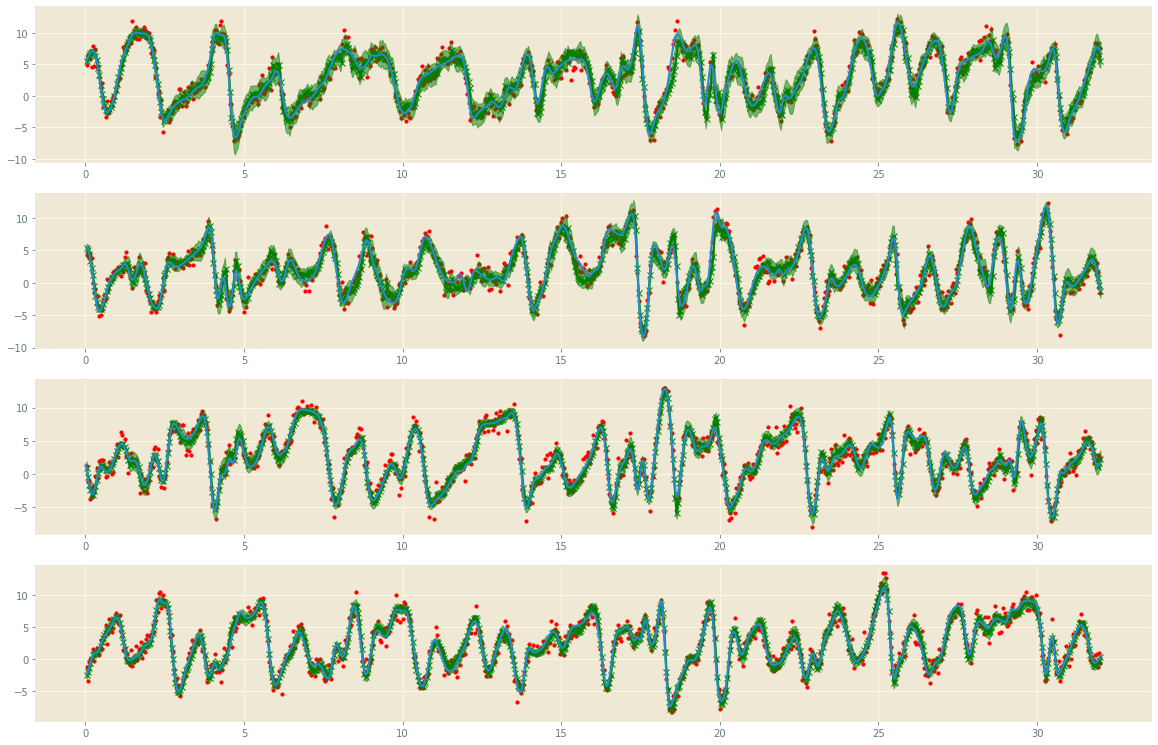

In [15]:
obs = np.array(dETKF["observations"])
xf = np.asarray(dETKF['ensemble_f'])
xfbar = xf.mean(2)
xa = np.asarray(dETKF['ensemble_a'])
xabar= xa.mean(2)
xa_std = xa.std(2)
plt.figure(figsize=(20, 20))
for i in range(4):
    plt.subplot(6, 1, i + 1)
    plt.scatter(dETKF["time"], obs[:, i], marker="o", c="red", s=10)
    # plt.scatter(dETKF["time"], xfbar[:, i], marker="x", color="green", s=20)
    plt.plot(dETKF["time"], xfbar[:, i], "x-", color="green")
    plt.fill_between(dETKF["time"], xabar[:, i] - 3*xa_std[:, i], xabar[:, i] + 3*xa_std[:, i], color="green", alpha=0.5)
    # plt.vlines(dETKF["time"], xfbar[:, i], xabar[:, i])
    plt.plot(truth.t[1001:], truth.state_vector[i, 1001:])
plt.show()

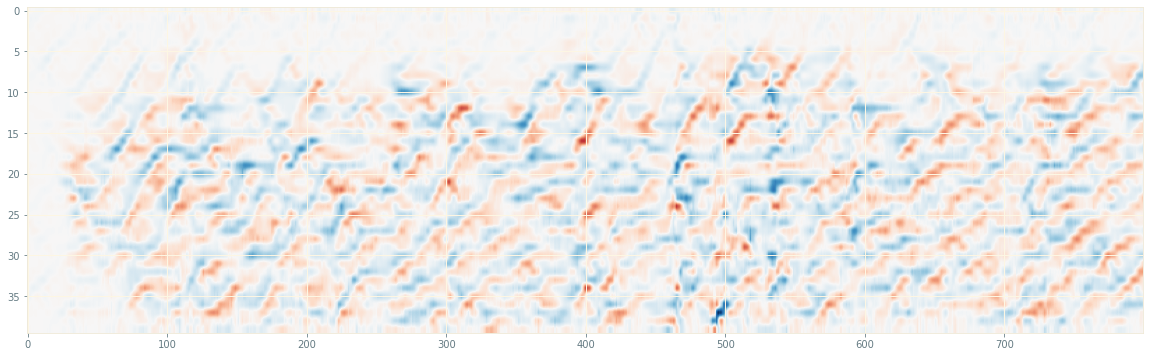

In [12]:
analysis_error = truth.state_vector[:, 1001::period_assim] - xabar.T
mi, ma = analysis_error.min(), analysis_error.max()
lim = max(np.abs(mi), np.abs(ma))
plt.figure(figsize=(20, 6))
plt.imshow(analysis_error, vmin=-lim, vmax=lim, cmap='RdBu', aspect='auto')

In [13]:
analysis_error = xabar[:, 0] - truth.state_vector[0, (1000+period_assim)::period_assim]
observation_error = obs[:, 0] - truth.state_vector[0, (1000+period_assim)::period_assim]
ea = ((analysis_error)**2).mean()
eo = ((observation_error)**2).mean()
print(f"{'Analysis error:': >20} {ea:>20}")
print(f"{'Observation error:': >20} {eo:>20}")

     Analysis error:   0.4822128893077615
  Observation error:   1.0224033118422198
